Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0.0859375
0.5625
0.859375
0.835938
0.898438
0.945312
0.90625
0.929688
0.960938
0.960938


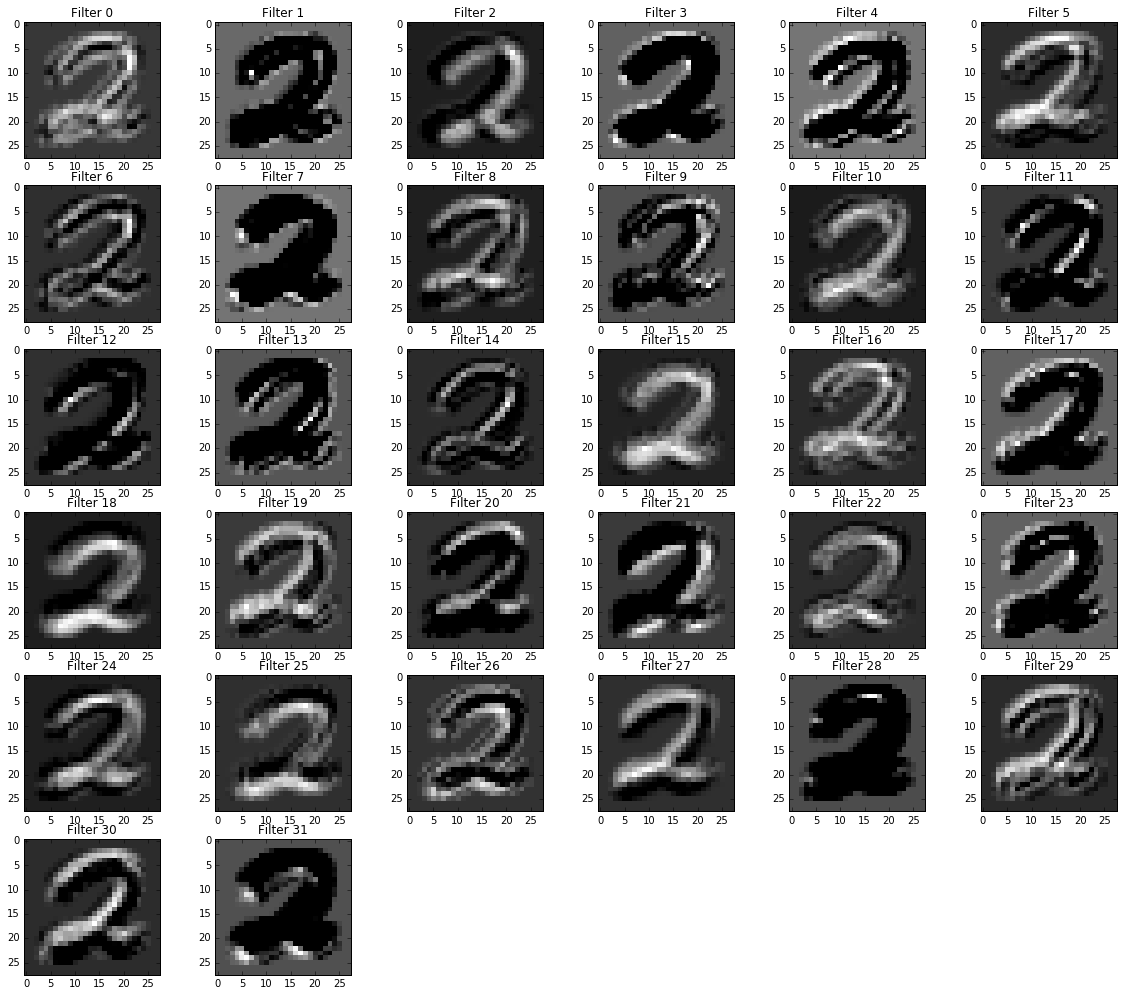

In [12]:


import numpy as np 
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Config
logs_path = "/tmp/tensorflow/log"
batch_size = 128
epochs = 100
learning_rate = 0.001


# setup
if tf.gfile.Exists(logs_path):
    tf.gfile.DeleteRecursively(logs_path)
tf.gfile.MakeDirs(logs_path)

tf.reset_default_graph()


# Helper functions
def weight_variable(shape, varName):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=varName)

def bias_variable(shape, varName):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=varName)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Create NN

# Placeholders

with tf.name_scope("input"):
    x = tf.placeholder(tf.float32, shape=[None, 784], name="x-input")
    y_ = tf.placeholder(tf.float32, shape=[None, 10], name="y-input")


with tf.name_scope("first_layer"):
    W_conv1 = weight_variable([5, 5, 1, 32], "weights")
    b_conv1 = bias_variable([32], "biases")

    x_image = tf.reshape(x, [-1,28,28,1])

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    #h_pool1 = max_pool_2x2(h_conv1)


with tf.name_scope('Visualize_filters') as scope:

    # In this section, we visualize the filters of the first convolutional layers
    # We concatenate the filters into one image
    # Credits for the inspiration go to Martin Gorner
  W1_a = W_conv1                       # [5, 5, 1, 32]
  W1pad= tf.zeros([5, 5, 1, 1])        # [5, 5, 1, 4]  - four zero kernels for padding
  # We have a 6 by 6 grid of kernepl visualizations. yet we only have 32 filters
  # Therefore, we concatenate 4 empty filters
  W1_b = tf.concat(3, [W1_a, W1pad, W1pad, W1pad, W1pad])   # [5, 5, 1, 36]
  W1_c = tf.split(3, 36, W1_b)         # 36 x [5, 5, 1, 1]
  W1_row0 = tf.concat(0, W1_c[0:6])    # [30, 5, 1, 1]
  W1_row1 = tf.concat(0, W1_c[6:12])   # [30, 5, 1, 1]
  W1_row2 = tf.concat(0, W1_c[12:18])  # [30, 5, 1, 1]
  W1_row3 = tf.concat(0, W1_c[18:24])  # [30, 5, 1, 1]
  W1_row4 = tf.concat(0, W1_c[24:30])  # [30, 5, 1, 1]
  W1_row5 = tf.concat(0, W1_c[30:36])  # [30, 5, 1, 1]
  W1_d = tf.concat(1, [W1_row0, W1_row1, W1_row2, W1_row3, W1_row4, W1_row5]) # [30, 30, 1, 1]
  W1_e = tf.reshape(W1_d, [1, 30, 30, 1])
  Wtag = tf.placeholder(tf.string, None)





with tf.name_scope("second_layer"):
    W_conv2 = weight_variable([5, 5, 32, 64], "weights")
    b_conv2 = bias_variable([64], "biases")

    h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)
    #h_pool2 = max_pool_2x2(h_conv2)

with tf.name_scope("fully_connected"):
    W_fc1 = weight_variable([28 * 28 * 64, 1024], "weights")
    b_fc1 = bias_variable([1024], "biases")

    h_pool2_flat = tf.reshape(h_conv2, [-1, 28*28*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

with tf.name_scope("dropout"):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

with tf.name_scope("output"):
    W_fc3 = weight_variable([1024, 10], "weights")
    b_fc3 = bias_variable([10], "biases")

    y_conv = tf.matmul(h_fc1_drop, W_fc3) + b_fc3

with tf.name_scope("cross_entropy"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))

with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


#create a summary for our cost and accuracy
tf.scalar_summary("cost", cross_entropy)
tf.scalar_summary("accuracy", accuracy)


summary_op = tf.merge_all_summaries()



sess = tf.Session()

train_writer = tf.train.SummaryWriter(logs_path + "/train", sess.graph)
test_writer = tf.train.SummaryWriter(logs_path + "/test")

#sess.initialize_all_variables().run()
sess.run(tf.initialize_all_variables())


for i in range(epochs):
    batch = mnist.train.next_batch(batch_size)
    if (i % 10 == 0):
        summ, acc = sess.run([summary_op, accuracy], feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})

        train_writer.add_summary(summ, i)

        print(acc)
    train_step.run(session=sess, feed_dict={x:batch[0],y_:batch[1], keep_prob:0.5})

    #train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

#print("Accuracy: "  + str(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})))
#print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
#print("test accuracy %g"%accuracy.eval(feed_dict={x:mnist[0], y_: mnist[1], keep_prob: 1.0}))

train_writer.close()
test_writer.close()

imageToUse = mnist.test.images[35]
plt.fig = plt.figure(figsize= (20,20))
plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap="gray")


getActivations(h_conv1,imageToUse)

In [2]:
def getActivations(layer,stimuli):
    units = layer.eval(session=sess,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)

In [3]:

def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    for i in xrange(0,filters):
        plt.subplot(7,6,i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

ValueError: num must be 1 <= num <= 42, not 43

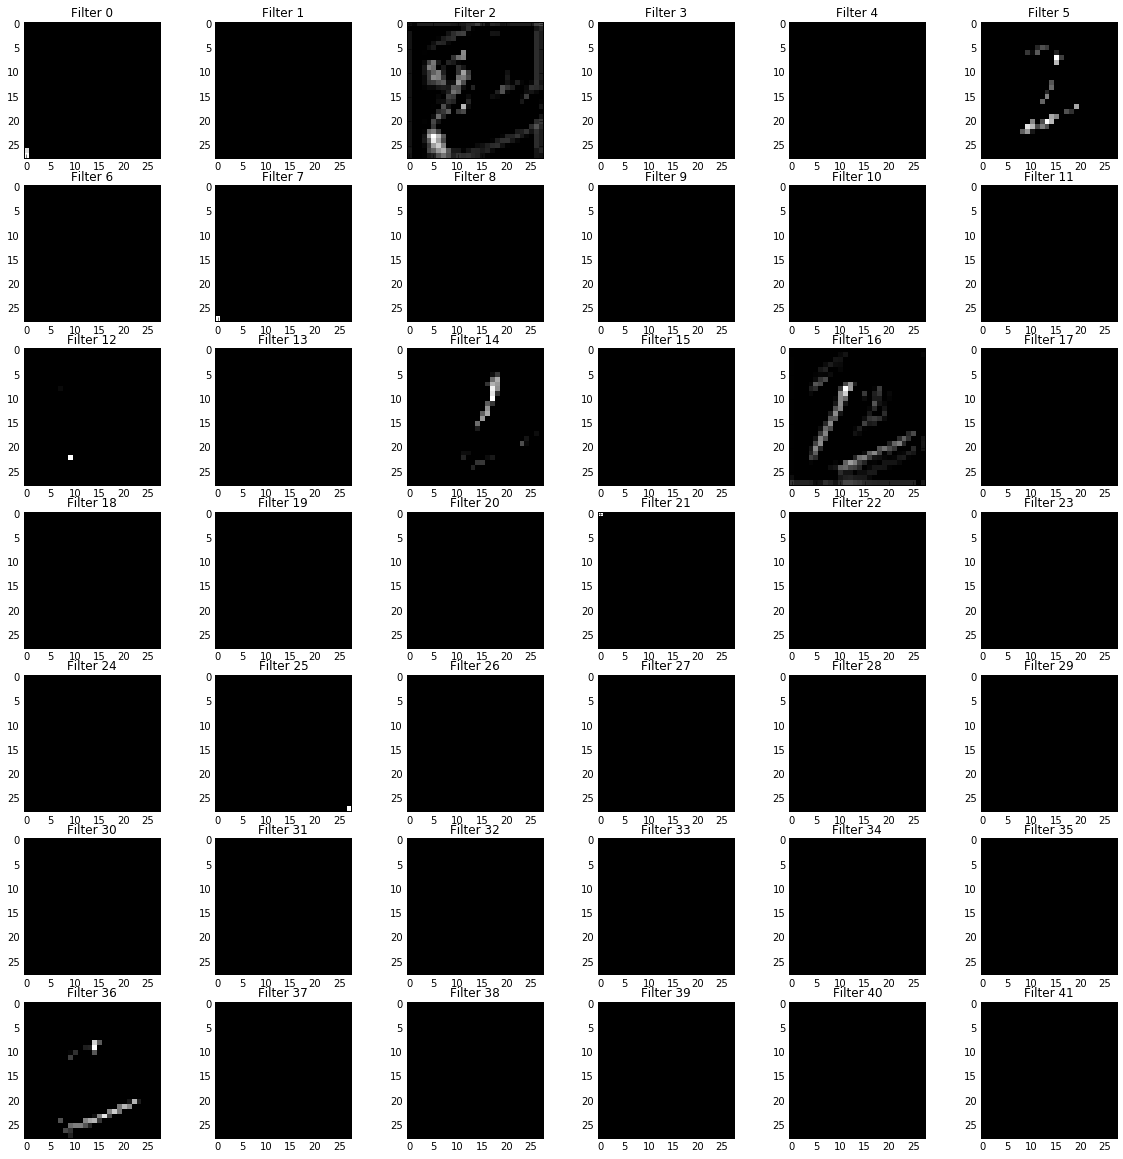

In [19]:
imageToUse = mnist.test.images[38]
plt.fig = plt.figure(figsize= (20,20))
plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap="gray")


getActivations(h_conv2,imageToUse)